##### Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from keras.layers import Activation, Dense, Flatten, Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPool2D
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.
/opt/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## 1. Data Preparation

#####  Instantiating ImageDataGenerator

In [2]:
# With data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False, # set input mean to 0 over the dataset
    samplewise_center=False, # set each sample mean to 0
    featurewise_std_normalization=False, # divide inputs by std of the dataset
    samplewise_std_normalization=False, # divide each inputs by its std
    zca_whitening=False, # apply ZCA whitening
    rotation_range=10, # randomly rotate images in the range (degrees, 0 to 10)
    zoom_range=0.1, # Randomly zoom image
    width_shift_range=0.1, # randomly shift image horizontally (fraction of total width)
    height_shift_range=0.1, # randomly shift image vertically (fraction of total height)
    horizontal_flip=False, # randomly flip images horizontally
    vertical_flip=False, # randomly flip images vertically
    rescale=1./255
)

In [3]:
train_dir = 'datasets/train/'
validation_dir = 'datasets/validation/'
test_dir = 'datasets/test/'

image_w, image_h = 128, 128
batch_size = 32

##### Load data

In [4]:
train_generator = datagen.flow_from_directory(train_dir, target_size=(image_w,image_h), batch_size=batch_size, class_mode='categorical')

Found 5300 images belonging to 10 classes.


In [5]:
validation_generator = datagen.flow_from_directory(validation_dir, target_size=(image_w, image_h), batch_size=batch_size, class_mode='categorical')

Found 570 images belonging to 10 classes.


## 2. CNN Model

In [6]:
def LeNet(width, height, channels, output):

    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(5, 5), strides=(2,2), input_shape=(width, height, channels)))
    model.add(Activation('relu'))
    model.add(Conv2D(filters=32, kernel_size=(5, 5), strides=(2,2), input_shape=(width, height, channels)))
    model.add(Activation('relu'))    

    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(2,2)))
    model.add(Activation('relu'))
    model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(2,2)))
    model.add(Activation('relu'))

    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(output))
    model.add(Activation('softmax'))
    
    return model

In [7]:
model = LeNet(image_w, image_h, 3, 2)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        2432      
_________________________________________________________________
activation_1 (Activation)    (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 32)        25632     
_________________________________________________________________
activation_2 (Activation)    (None, 29, 29, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 64)          18496     
__________

In [8]:
model = LeNet(image_w, image_h, 3, 10)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 62, 62, 32)        2432      
_________________________________________________________________
activation_7 (Activation)    (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 29, 29, 32)        25632     
_________________________________________________________________
activation_8 (Activation)    (None, 29, 29, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 6, 64)          18496     
__________

##### Set the optimizer and annealer

In [9]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [10]:
# Compile the model
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [11]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)


##### Model Fitting

In [12]:
EPOCH = 10
train_samples = train_generator.samples
validation_samples = validation_generator.samples

In [13]:
history = model.fit_generator(
    train_generator, 
    steps_per_epoch = train_samples // batch_size, 
    epochs = EPOCH, 
    validation_data = validation_generator,
    validation_steps= validation_samples // batch_size,
    callbacks=[learning_rate_reduction]
)

Epoch 1/10
165/165 [==============================] - 68s 411ms/step - loss: 2.0694 - acc: 0.2280 - val_loss: 1.4880 - val_acc: 0.4890
Epoch 2/10
165/165 [==============================] - 69s 419ms/step - loss: 1.4721 - acc: 0.4651 - val_loss: 1.1554 - val_acc: 0.5680
Epoch 3/10
165/165 [==============================] - 84s 508ms/step - loss: 1.1873 - acc: 0.5889 - val_loss: 0.8532 - val_acc: 0.7224
Epoch 4/10
165/165 [==============================] - 83s 501ms/step - loss: 1.0000 - acc: 0.6631 - val_loss: 0.7600 - val_acc: 0.7592
Epoch 5/10
165/165 [==============================] - 83s 502ms/step - loss: 0.8789 - acc: 0.7004 - val_loss: 0.5582 - val_acc: 0.8015
Epoch 6/10
165/165 [==============================] - 73s 445ms/step - loss: 0.7784 - acc: 0.7336 - val_loss: 0.5895 - val_acc: 0.7996
Epoch 7/10
165/165 [==============================] - 71s 429ms/step - loss: 0.7016 - acc: 0.7594 - val_loss: 0.5257 - val_acc: 0.8070
Epoch 8/10
165/165 [==============================] - 7

In [14]:
model.save_weights('models/epochs-20-model-20180313-02.h5')

## 3. Model Evaluation

In [15]:
test_img = load_img('datasets/test/nin.png', target_size=(image_w, image_h))
#test_img = datagen.flow_from_directory(test_dir, target_size=(image_w, image_h), batch_size=batch_size, class_mode='categorical')

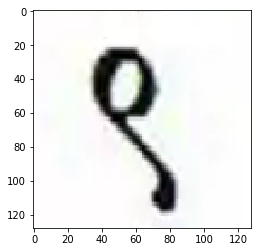

In [16]:
plt.imshow(test_img)

In [17]:
test_img = np.array(test_img) / 255
test_img = np.expand_dims(test_img, axis = 0)

In [18]:
prediction = model.predict(test_img)
prediction

array([[  1.08762215e-05,   1.54241876e-04,   9.16286051e-01,
          7.29153827e-02,   3.12708365e-03,   4.00581956e-03,
          1.33124366e-03,   2.68777745e-04,   5.18757734e-05,
          1.84865436e-03]], dtype=float32)

In [19]:
np.argsort(-prediction)

array([[2, 3, 5, 4, 9, 6, 7, 1, 8, 0]])